In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('synergy_all_playtypes_2015_to_2025.csv')
df.head()

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,TYPE_GROUPING,PERCENTILE_Isolation,GP_Isolation,POSS_PCT_Isolation,...,TOV_POSS_PCT_Misc,SF_POSS_PCT_Misc,PLUSONE_POSS_PCT_Misc,SCORE_POSS_PCT_Misc,EFG_PCT_Misc,POSS_Misc,PTS_Misc,FGM_Misc,FGA_Misc,FGMX_Misc
0,22015,708,Kevin Garnett,1610612750,MIN,Minnesota Timberwolves,Offensive,NaN,NaN,NaN,...,0.824,0.000,0.00,0.176,0.000,0.4,0.1,0.0,0.0,0.0
1,22015,977,Kobe Bryant,1610612747,LAL,Los Angeles Lakers,Offensive,0.292,66.0,0.199,...,0.407,0.051,0.00,0.254,0.119,0.9,0.5,0.0,0.3,0.3
2,22015,1495,Tim Duncan,1610612759,SAS,San Antonio Spurs,Offensive,NaN,NaN,NaN,...,0.803,0.015,0.00,0.167,0.600,1.1,0.3,0.0,0.1,0.0
3,22015,1713,Vince Carter,1610612763,MEM,Memphis Grizzlies,Offensive,0.021,60.0,0.049,...,0.286,0.071,0.04,0.500,0.500,0.5,0.5,0.1,0.2,0.1
4,22015,1717,Dirk Nowitzki,1610612742,DAL,Dallas Mavericks,Offensive,0.938,75.0,0.046,...,0.383,0.000,0.00,0.500,0.222,0.8,0.7,0.0,0.1,0.1


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 9.000e+00, 6.000e+00, 6.000e+00,
        9.000e+00, 7.000e+00, 1.500e+01, 1.500e+01, 1.700e+01, 1.500e+01,
        1.100e+01, 1.200e+01, 1.600e+01, 1.600e+01, 2.100e+01, 2.300e+01,
        1.700e+01, 2.700e+01, 3.100e+01, 2.700e+01, 3.600e+01, 3.400e+01,
        4.600e+01, 3.900e+01, 4.500e+01, 4.800e+01, 5.700e+01, 5.900e+01,
        6.600e+01, 4.800e+01, 8.800e+01, 8.100e+01, 9.200e+01, 1.140e+02,
        1.400e+02, 1.430e+02, 1.920e+02, 3.120e+02, 5.220e+02, 1.208e+03,
        1.032e+03, 1.000e+00]),
 array([0.084  , 0.10294, 0.12188, 0.14082, 0.15976, 0.1787 , 0.19764,
        0.21658, 0.23552, 0.25446, 0.2734 , 0.29234, 0.31128, 0.33022,
        0.34916, 0.3681 , 0.38704, 0.40598, 0.42492, 0.44386, 0.4628 ,
        0.48174, 0.50068, 0.51962, 0.53856, 0.5575 , 0.57644, 0.59538,
        0.61432, 0.63326, 0.6522 , 0.67114, 0.69008, 0.70902, 0.72796,
        0.7469 , 0.76

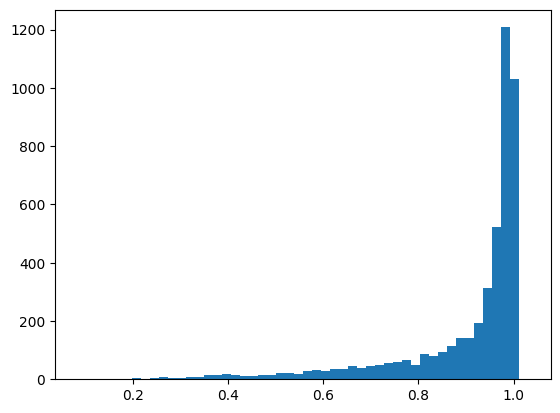

In [3]:
poss_cols = [col for col in df.columns if 'POSS_PCT' == col[:8]]

df['total_poss'] = df[poss_cols].sum(axis=1)

plt.hist(df['total_poss'], bins=50)

In [4]:
# get rid of extra columns
to_delete = ['FGA', 'FGM', 'FGX', 'PERCENTILE', 'POSS', 'PTS', 'GP']
cols_to_delete = []
for col in df.columns:

    for i in to_delete:
        if i == col[:len(i)] and 'PCT' not in col:
            cols_to_delete.append(col)

cols_to_delete += ['PLAYER_ID', 'TEAM_ID', 'TYPE_GROUPING']

df = df.drop(columns=cols_to_delete)
df.fillna(0, inplace=True)

In [5]:
X = df.drop(columns=['SEASON_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'SEASON']).to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, name_train, name_test= train_test_split(X, df[['PLAYER_NAME','SEASON']], test_size=0.2, random_state=42)

In [12]:
torch.manual_seed(42)


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim):
        super(AutoEncoder, self).__init__()

        # create encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, int(hidden_dim / 2)),
            nn.ReLU(True),
            nn.Linear(int(hidden_dim / 2), encoding_dim),\
            nn.ReLU(True)
        )
        # create decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, int(hidden_dim / 2)),
            nn.ReLU(True),
            nn.Linear(int(hidden_dim / 2), hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

    # create the forward pass
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    # create encode function
    def encode(self, x):
        x = self.encoder(x)
        return x
    
# create training function
def train_autoencoder(model, data_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for data in data_loader:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(data)
            loss = criterion(outputs, data)

            # backward pass and optimization
            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
train_loader = DataLoader(X_train_tensor, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test_tensor, batch_size=32, shuffle=False)


train_loader = DataLoader(X_train_tensor, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test_tensor, batch_size=32, shuffle=False)

# set the hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 128
encoded_dim = 3
batch_size = 32
num_epochs = 50
learning_rate = 0.0001


for embed_dim in range(2,5):

    encoded_dim = embed_dim


    # create the model
    model = AutoEncoder(input_dim, hidden_dim, encoded_dim)
    # create the loss function
    criterion = nn.MSELoss()
    # create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)

    # test the model
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            outputs = model(data)
            loss = criterion(outputs, data)
            print(f'Test Loss: {loss.item():.4f} With Embedding Dim: {embed_dim}')
            break

Test Loss: 0.0504 With Embedding Dim: 2
Test Loss: 0.0366 With Embedding Dim: 3
Test Loss: 0.0503 With Embedding Dim: 4


In [17]:
encoded_dim = 3


# create the model
model = AutoEncoder(input_dim, hidden_dim, encoded_dim)
# create the loss function
criterion = nn.MSELoss()
# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)

model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = model(data)
        loss = criterion(outputs, data)
        print(f'Test Loss: {loss.item():.4f} With Embedding Dim: {encoded_dim}')
        break


x_test_results = model.encode(X_test_tensor)
x_test_results = x_test_results.detach().numpy()
x_test_results = pd.DataFrame(x_test_results)
x_test_results[['PLAYER_NAME', 'SEASON']] = name_test.reset_index(drop=True)

x_test_results.head()




Test Loss: 0.0390 With Embedding Dim: 3


,0,1,2,PLAYER_NAME,SEASON
0,3.334219,4.131370,2.372295,Taurean Prince,2017-18
1,3.520122,4.427368,2.169397,Terry Rozier,2019-20
2,1.361443,3.186098,1.647641,Kenrich Williams,2022-23
3,4.743515,2.194544,2.685072,Jaden Hardy,2022-23
4,4.587844,1.294222,2.791007,Matt Thomas,2019-20


In [18]:
# create the scatter plot
x_test_results['size'] = .00001

import plotly.express as px
fig = px.scatter_3d(x_test_results, x=0, y=1, z=2,
              hover_data=['PLAYER_NAME', 'SEASON'], size='size',
              title='3D Scatter Plot of Player Embeddings',)
fig.show()